In [3]:
file_path = "../../../testdata/test2.nd2"
output_dir = "../../../testdata/test2_output"
metadata_path : str = "../../../testdata/test2_output/test2_metadata.yaml"
corrected_filename = "shading_corrected.zarr"
profile_filename = "shading_profile.zarr"

mode = "additive"
local_subtraction_channels = "*DIA*"
local_subtraction_scaling = 0.1
local_subtraction_median_disk_size=4
num_cpus=10

In [4]:
assert mode in ["multiplicative", "additive"], "mode must be either 'multiplicative' or 'additive'"

In [5]:
from pathlib import Path

def to_path(x):
    return Path(x).absolute()

_file_path = to_path(file_path)
_output_dir = to_path(output_dir)
_metadata_path = to_path(metadata_path)

# Import packages and define functions

In [6]:
from aicsimageio import AICSImage
from matplotlib import pyplot as plt
import numpy as np
import zarr
import yaml
from utils import read_mosaic_image, open_zarr_with_synchronizer
from common import local_subtraction_2d_ignore_zero, match_pattern
from joblib import Parallel, delayed

In [7]:
metadata = yaml.safe_load(Path(_metadata_path).read_text())
channel_names = metadata["channel_names"]
mosaic_dim = metadata["mosaic_dim"]
print(channel_names, mosaic_dim)

['10x_Fukai_DIA_IS', '10x_Fukai_DIA_IS', '10x_Fukai_mCherry_IS', '10x_Fukai_EGFP_IS'] scene


# Shading correction

## Open images 

In [24]:
aics_image = AICSImage(_file_path,reconstruct_mosaic=False) 
image = read_mosaic_image(aics_image, mosaic_dim, "TCZYX")
image.shape

(48, 2, 4, 1, 2296, 2656)

## Output files

In [9]:
chunks = [1] * len(image.shape[:-2]) + list(image.shape[-2:])
zarr_path = _output_dir/corrected_filename
corrected_zarr = open_zarr_with_synchronizer(zarr_path, shape=image.shape, chunks=chunks, dtype=np.float32)

In [10]:
profile_path = _output_dir/profile_filename
profile_zarr = zarr.open(str(profile_path), mode="r")

## Correct shading

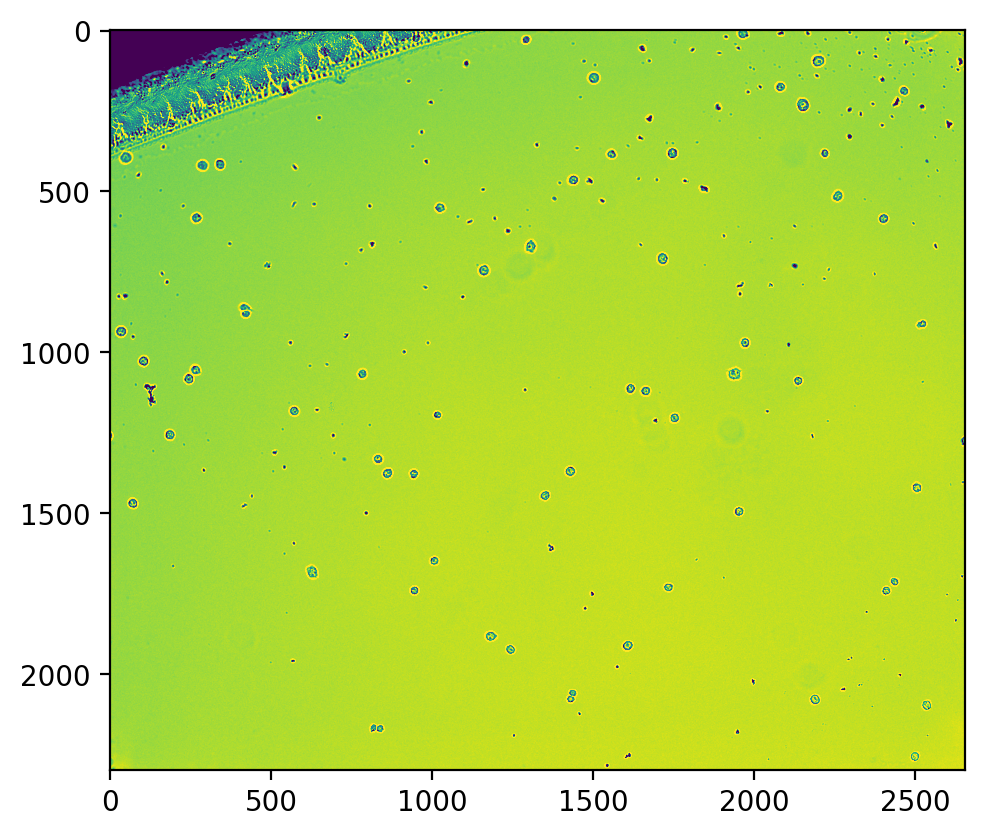

In [11]:
vmin, vmax = np.percentile(np.ravel(image[0,0,0]), (1, 99))
plt.imshow(image[0,0,0,0], vmin=vmin, vmax=vmax)

In [12]:
inds = list(np.ndindex(image.shape[:3]))

In [17]:
def to_new_ind(ind, shape):
    new_ind = []
    for i, s in zip(ind, shape):
        if s == 1:
            new_ind.append(0)
        else:
            new_ind.append(i)
    return tuple(new_ind)
ind = inds[-1]
ind
profile_zarr[to_new_ind(ind, profile_zarr.shape)]

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [18]:
def process_image(ind, do_local_subtraction):
    im = image[ind]
    p = profile_zarr[to_new_ind(ind, profile_zarr.shape)]
    if mode == "multiplicative":
        image2 = np.array(im / p).astype(np.float32)
    elif mode == "additive":
        image2 = np.array(im - p).astype(np.float32)    
    if do_local_subtraction:
        image3 = np.empty_like(image2)
        for inds in np.ndindex(image2.shape[:-2]):
            image3[inds] = local_subtraction_2d_ignore_zero(
                image2[inds], 
                local_subtraction_scaling, 
                local_subtraction_median_disk_size)
        image2 = image3
    corrected_zarr[ind] = image2

In [19]:
# FILEPATH: /work/fukai/image_analysis/microflow/scripts/b1_shading_correction_median/each_frame/b1_b_shading_correction.ipynb
inds = list(np.ndindex(image.shape[:3]))
do_local_subtractions = [local_subtraction_channels == "all" or match_pattern(local_subtraction_channels, channel_names[c]) for (_m,_t,c) in inds]

with Parallel(n_jobs=num_cpus) as parallel:
    parallel(delayed(process_image)(ind, do_local_subtraction) for ind, do_local_subtraction in zip(inds, do_local_subtractions));

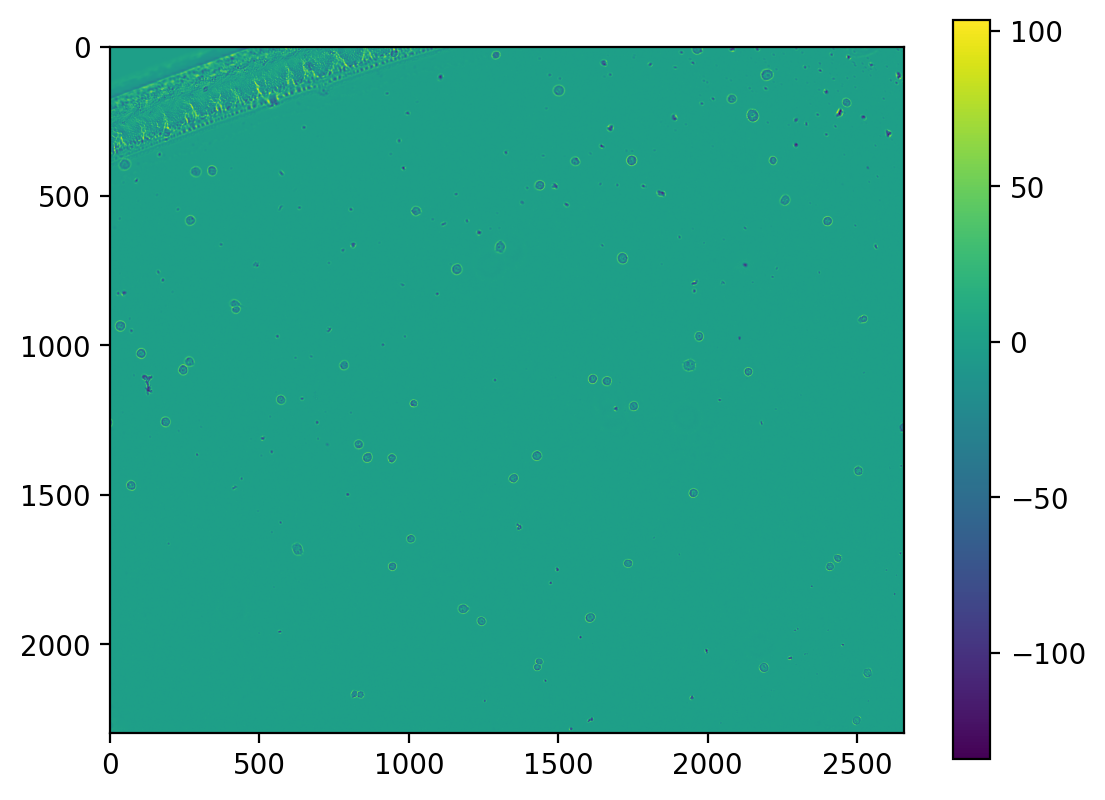

In [20]:
vmin, vmax = np.percentile(np.ravel(corrected_zarr[0,0,0,0]), (0.0001, 99.9999))
plt.imshow(corrected_zarr[0,0,0,0], vmin=vmin, vmax=vmax)
plt.colorbar()

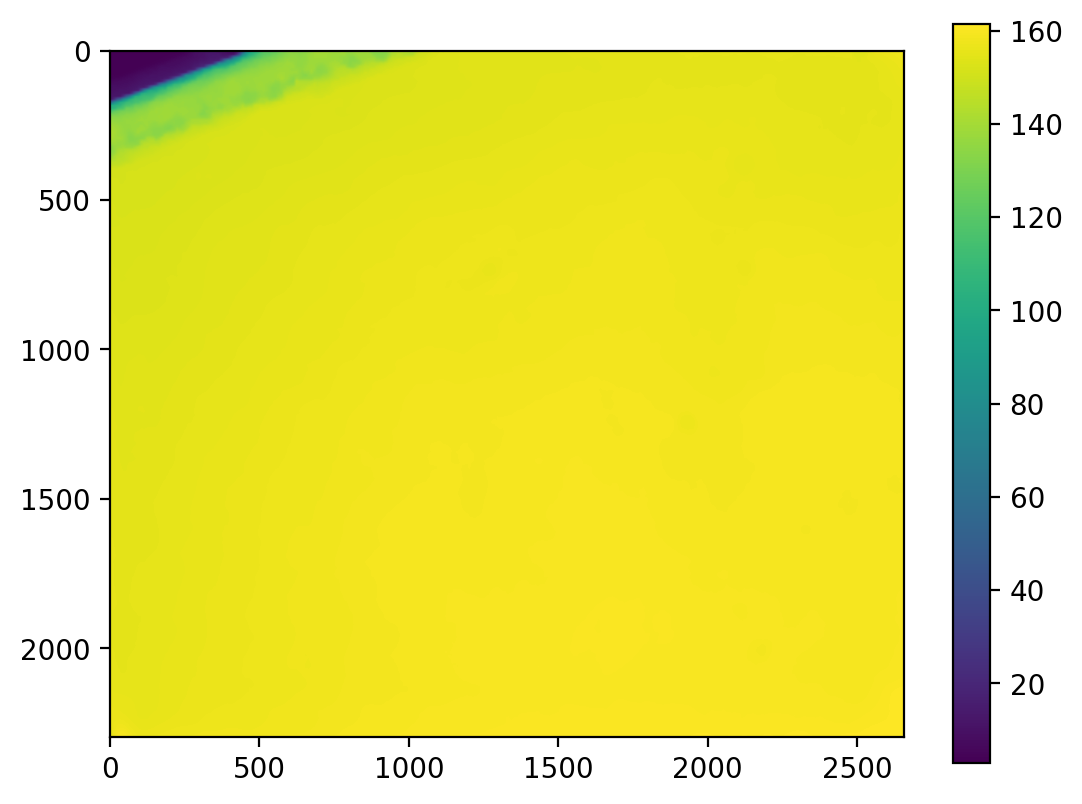

In [21]:
diff = image[0,0,0,0]-corrected_zarr[0,0,0,0]
vmin, vmax = np.percentile(np.ravel(diff), (0.1, 99.9))
plt.imshow(diff,vmin=vmin, vmax=vmax)
plt.colorbar()